In [88]:
from skimage import io, transform, color
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image
import os

from dataLoader import OrganoidDataset
#from conv_model import SimpleConvNet
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# global variables

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

In [3]:
figure_path = '../milestoneReport/figures/'
path = '../data/CS231n_Tim_Shan_example_data/'
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

# load data

In [4]:
label = pd.read_csv(label_path)
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','hyst1_area','hyst2_area']
label.columns = new_columns

In [5]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [6]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [21]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,hyst1_area,hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [7]:
corrected_labels = label.query("mw_area_shape < 32000")

In [8]:
corrected_labels.loc[:,'has_cell'] = np.int64(corrected_labels['hyst2_area'] > 0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
def get_day_description(corrected_labels,day):
    df = corrected_labels.query("day == %d"%day)[['well_id','day','well_label','image_name','has_cell']]
    day_suffix = '_' + str(day)
    df = df.rename(columns={'day':'day'+day_suffix, 'has_cell':'has_cell'+day_suffix,'image_name':'image_name'+day_suffix})
    return df

In [32]:
day1wells = get_day_description(corrected_labels,1)
day2wells = get_day_description(corrected_labels,8)
day13wells = get_day_description(corrected_labels,13)

In [33]:
day1wells.shape, day2wells.shape, day13wells.shape

((4721, 5), (4642, 5), (4712, 5))

In [34]:
merged_days = day1wells.merge(day2wells,on=['well_id','well_label']).merge(day13wells,on=['well_id','well_label'])

In [35]:
merged_days.shape

(4516, 11)

In [36]:
#shuffle dataframe
merged_days = merged_days.sample(frac=1).reset_index(drop=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20959c17f0>,
      dtype=object)

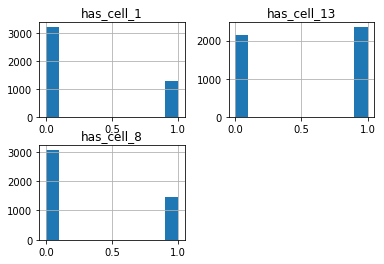

In [28]:
merged_days[['has_cell_1','has_cell_8','has_cell_13']].hist()

In [37]:
merged_days.head(2)

,well_id,day_1,well_label,image_name_1,has_cell_1,day_8,image_name_8,has_cell_8,day_13,image_name_13,has_cell_13
0,1705,1,1705,well1705_day01_well.png,0,8,well1705_day08_well.png,0,13,well1705_day13_well.png,1
1,4511,1,4511,well4511_day01_well.png,1,8,well4511_day08_well.png,0,13,well4511_day13_well.png,1


### test image

In [40]:
image_name = 'well1705_day01_well.png'

In [60]:
image = imread(path+image_name)

In [61]:
image

Array([[[139, 139, 139, 255],
        [134, 134, 134, 255],
        [130, 130, 130, 255],
        ...,
        [134, 134, 134, 255],
        [135, 135, 135, 255],
        [128, 128, 128, 255]],

       [[134, 134, 134, 255],
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        ...,
        [134, 134, 134, 255],
        [134, 134, 134, 255],
        [130, 130, 130, 255]],

       [[131, 131, 131, 255],
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        ...,
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        [130, 130, 130, 255]],

       ...,

       [[127, 127, 127, 255],
        [128, 128, 128, 255],
        [128, 128, 128, 255],
        ...,
        [131, 131, 131, 255],
        [130, 130, 130, 255],
        [128, 128, 128, 255]],

       [[127, 127, 127, 255],
        [128, 128, 128, 255],
        [130, 130, 130, 255],
        ...,
        [130, 130, 130, 255],
        [128, 128, 128, 255],
        [128, 128, 128, 255]],

       [[128

In [48]:
image.shape

(193, 193, 4)

In [50]:
color.rgb2gray(image)

array([[0.54509804, 0.5254902 , 0.50980392, ..., 0.5254902 , 0.52941176,
        0.50196078],
       [0.5254902 , 0.51372549, 0.51372549, ..., 0.5254902 , 0.5254902 ,
        0.50980392],
       [0.51372549, 0.51372549, 0.51372549, ..., 0.51372549, 0.51372549,
        0.50980392],
       ...,
       [0.49803922, 0.50196078, 0.50196078, ..., 0.51372549, 0.50980392,
        0.50196078],
       [0.49803922, 0.50196078, 0.50980392, ..., 0.50980392, 0.50196078,
        0.50196078],
       [0.50196078, 0.50196078, 0.50196078, ..., 0.50980392, 0.50980392,
        0.50980392]])

In [51]:
day1_mean_and_var = pd.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

In [52]:
day1_mean_and_var

,mean,variance
0,0.504038,0.026985


In [63]:
image = color.rgb2gray(image)

In [64]:
image.shape

(193, 193)

In [65]:
image2 = image.copy()

In [ ]:
np.concatenate

In [56]:
image = np.reshape(image, newshape = (1, image.shape[0], image.shape[1]))

In [57]:
image.shape

(1, 193, 193)

In [58]:
torch_image = torch.from_numpy(image).float()

In [66]:
torch_image

tensor([[[0.5451, 0.5255, 0.5098,  ..., 0.5255, 0.5294, 0.5020],
         [0.5255, 0.5137, 0.5137,  ..., 0.5255, 0.5255, 0.5098],
         [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5098],
         ...,
         [0.4980, 0.5020, 0.5020,  ..., 0.5137, 0.5098, 0.5020],
         [0.4980, 0.5020, 0.5098,  ..., 0.5098, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5098, 0.5098]]])

In [74]:
np.concatenate((image,image2),axis=0).shape

(386, 193)

In [76]:
np.array([image,image2]).shape

(2, 193, 193)

In [79]:
image_names = {1:merged_days['image_name_1'],8:merged_days['image_name_8']}

In [80]:
mean_sd_dict={1:[0.5,0.02],8:[0.5,0.02]}

In [81]:
index = 0

In [84]:
np.array([]).append(image)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [96]:
    all_images_list = []
    for day,img_names in image_names.items():
        img_name = img_names[index]
        img_loc = os.path.join(path, img_name)
        image = io.imread(img_loc)
        mean, sd = mean_sd_dict[day]
        image = np.true_divide(color.rgb2gray(image) - mean, sd)
        all_images_list.append(image)
    images = np.array(all_images_list)

In [97]:
images

array([[[ 2.25490196,  1.2745098 ,  0.49019608, ...,  1.2745098 ,
          1.47058824,  0.09803922],
        [ 1.2745098 ,  0.68627451,  0.68627451, ...,  1.2745098 ,
          1.2745098 ,  0.49019608],
        [ 0.68627451,  0.68627451,  0.68627451, ...,  0.68627451,
          0.68627451,  0.49019608],
        ...,
        [-0.09803922,  0.09803922,  0.09803922, ...,  0.68627451,
          0.49019608,  0.09803922],
        [-0.09803922,  0.09803922,  0.49019608, ...,  0.49019608,
          0.09803922,  0.09803922],
        [ 0.09803922,  0.09803922,  0.09803922, ...,  0.49019608,
          0.49019608,  0.49019608]],

       [[ 2.25490196,  1.8627451 ,  2.25490196, ...,  1.07843137,
          1.07843137,  0.29411765],
        [ 2.25490196,  1.47058824,  0.68627451, ...,  1.07843137,
          1.07843137,  1.07843137],
        [ 0.09803922,  0.29411765,  0.09803922, ...,  0.68627451,
          0.68627451,  1.47058824],
        ...,
        [ 1.07843137,  0.29411765,  0.29411765, ...,  

In [95]:
np.array(all_images).shape

(2, 193, 193)

In [ ]:
class OrganoidMultipleDataset(data.Dataset):
  'dataset class for microwell organoid images'
  def __init__(self, path2files, well_labels, day_label_X, Y, intensity_mean, intensity_var):
    assert len(well_labels) == len(Y)
    assert len(day_label_X) == len(Y)
    self.path = path2files
    #self.mw_labels = microwell_labels
    self.well_labels = well_labels
    self.day_label_X = day_label_X
    self.Y = Y
    self.mean = intensity_mean
    self.sd = math.sqrt(intensity_var)
  def __len__(self):
    return len(self.Y)
  def getXimage(self, index):
        all_images_list = []
        for day,img_names in self.image_names.items():
            img_name = img_names[index]
            img_loc = os.path.join(self.path, img_name)
            image = io.imread(img_loc)
            mean, sd = self.mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            all_images_list.append(image)
    images = np.array(all_images_list)
    return torch.from_numpy(images).float()
  def getY(self, index):
    Y = self.Y[index]
    return torch.from_numpy(np.asarray(self.Y[index], dtype=float)).float()
  def __getitem__(self, index):
    X = self.getXimage(index)
    y = self.getY(index)
    return X, y

In [ ]:
merged_days.plot(x='well_id',y=['has_cell_1','has_cell_8','has_cell_13'],kind='bar')